## Import Libraries

In [245]:
import pandas as pd
import numpy as np
import re
import psycopg2 as sql
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score

## 1.	Load Data

In [246]:
read_csv = pd.read_csv('data.csv')
raw_data=pd.DataFrame(read_csv)

##### Preview Data

In [407]:
raw_data.head(10)

,Names,Prices_$,Descriptions,Ratings,Reviews
0,Packard 255 G2,416.99,"15.6"", AMD E2-3800 1.3GHz, 4GB, 500GB, Windows...",2,2
1,Aspire E1-510,306.99,"15.6"", Pentium N3520 2.16GHz, 4GB, 500GB, Linux",3,2
2,Thinkpad T540P,1178.99,"15.6"", Core i5-4200M, 4GB, 500GB, Win7 Pro 64bit",1,2
3,Probook,739.99,"14"", Core i5 2.6GHz, 4GB, 500GB, Win7 Pro 64bit",4,8
4,Thinkpad X240,1311.99,"12.5"", Core i5-4300U, 8GB, 240GB SSD, Win7 Pro...",3,12
5,Aspire E1-572G,581.99,"15.6"", Core i5-4200U, 8GB, 1TB, Radeon R7 M265...",1,2
6,Thinkpad Yoga,1033.99,"12.5"" Touch, Core i3-4010U, 4GB, 500GB + 16GB ...",2,13
7,Pavilion,609.99,"15.6"", Core i5-4200U, 6GB, 750GB, Windows 8.1",1,4
8,Inspiron 15,745.99,"Moon Silver, 15.6"", Core i7-4510U, 8GB, 1TB, R...",3,12
9,Dell Xps 13,1281.99,"13.3"" Touch, Core i5-4210U, 8GB, 128GB SSD, Wi...",3,4


In [248]:
raw_data.tail()

,Names,Prices,Descriptions,Ratings,Reviews
112,\nLenovo ThinkPa...\n,$1349.23,"Lenovo ThinkPad T470, 14"" FHD IPS, Core i5-720...",1,5
113,\nLenovo ThinkPa...\n,$1362.24,"Lenovo ThinkPad Yoga 370 Black, 13.3"" FHD IPS ...",2,12
114,\nToshiba Porteg...\n,$1366.32,"Toshiba Portege X20W-D-10V Black/Blue, 12.5"" F...",1,11
115,\nAsus ASUSPRO B...\n,$1381.13,"Asus ASUSPRO B9440UA-GV0279R Gray, 14"" FHD, Co...",1,4
116,\nAsus ROG Strix...\n,$1399,"Asus ROG Strix GL702VM-GC146T, 17.3"" FHD, Core...",3,10


## 2. Data Exploration

#### *Data Quality Checks*

##### *Number of rows and columns*

In [249]:
print(f'(Rows,Columns)-->{raw_data.shape}')

(Rows,Columns)-->(117, 5)


##### *2. Data Checks*

In [250]:
raw_data.dtypes

Names           object
Prices          object
Descriptions    object
Ratings          int64
Reviews          int64
dtype: object

#### *Identify Missing Values*

In [251]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Names         117 non-null    object
 1   Prices        117 non-null    object
 2   Descriptions  117 non-null    object
 3   Ratings       117 non-null    int64 
 4   Reviews       117 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 4.7+ KB


#### *Understand the distinct values in each column*

In [252]:
for i in raw_data.columns:
    print(f'{i}:{raw_data[i].nunique()}')
    

Names:52
Prices:108
Descriptions:116
Ratings:4
Reviews:15


#### *Descriptive stats about the data*

In [253]:
raw_data.describe()

,Ratings,Reviews
count,117.000000,117.000000
mean,2.341880,6.897436
std,1.107672,4.255594
min,1.000000,0.000000
25%,1.000000,3.000000
50%,2.000000,7.000000
75%,3.000000,10.000000
max,4.000000,14.000000


## 3.	Data Cleaning

#### *Correcting Errors*

###### *1. Remove Whitespaces on column: Names*

In [254]:
raw_data['Names']=raw_data['Names'].str.strip()

###### *2. Fix Names that contains '...'*

In [255]:
#Data Containing '...'
data_with_dots=raw_data[raw_data['Names'].str.contains('...',regex=False)]

data_with_dots['Names']=data_with_dots['Descriptions'].str.split(',',expand=True)[0]
#x=data_with_dots['Names'].str.contains('...',regex=False)
#Data Not Containing '...'
data_without_dots=raw_data[~raw_data['Names'].str.contains('...',regex=False)]
#Combine Data
raw_data=pd.concat([data_with_dots,data_without_dots],axis=0).sort_index(ascending=True)
raw_data

C:\Users\SaneleZondo\AppData\Local\Temp\ipykernel_31212\1554343080.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_with_dots['Names']=data_with_dots['Descriptions'].str.split(',',expand=True)[0]


,Names,Prices,Descriptions,Ratings,Reviews
0,Packard 255 G2,$416.99,"15.6"", AMD E2-3800 1.3GHz, 4GB, 500GB, Windows...",2,2
1,Aspire E1-510,$306.99,"15.6"", Pentium N3520 2.16GHz, 4GB, 500GB, Linux",3,2
2,ThinkPad T540p,$1178.99,"15.6"", Core i5-4200M, 4GB, 500GB, Win7 Pro 64bit",1,2
3,ProBook,$739.99,"14"", Core i5 2.6GHz, 4GB, 500GB, Win7 Pro 64bit",4,8
4,ThinkPad X240,$1311.99,"12.5"", Core i5-4300U, 8GB, 240GB SSD, Win7 Pro...",3,12
...,...,...,...,...,...
112,Lenovo ThinkPad T470,$1349.23,"Lenovo ThinkPad T470, 14"" FHD IPS, Core i5-720...",1,5
113,Lenovo ThinkPad Yoga 370 Black,$1362.24,"Lenovo ThinkPad Yoga 370 Black, 13.3"" FHD IPS ...",2,12
114,Toshiba Portege X20W-D-10V Black/Blue,$1366.32,"Toshiba Portege X20W-D-10V Black/Blue, 12.5"" F...",1,11
115,Asus ASUSPRO B9440UA-GV0279R Gray,$1381.13,"Asus ASUSPRO B9440UA-GV0279R Gray, 14"" FHD, Co...",1,4


###### *3. Remove dollar sign($) to help us with changing data type*

In [256]:
raw_data['Prices']=raw_data['Prices'].str.replace('$','').str.strip()
raw_data.rename(columns={'Prices':'Prices_$'},inplace=True)
raw_data

,Names,Prices_$,Descriptions,Ratings,Reviews
0,Packard 255 G2,416.99,"15.6"", AMD E2-3800 1.3GHz, 4GB, 500GB, Windows...",2,2
1,Aspire E1-510,306.99,"15.6"", Pentium N3520 2.16GHz, 4GB, 500GB, Linux",3,2
2,ThinkPad T540p,1178.99,"15.6"", Core i5-4200M, 4GB, 500GB, Win7 Pro 64bit",1,2
3,ProBook,739.99,"14"", Core i5 2.6GHz, 4GB, 500GB, Win7 Pro 64bit",4,8
4,ThinkPad X240,1311.99,"12.5"", Core i5-4300U, 8GB, 240GB SSD, Win7 Pro...",3,12
...,...,...,...,...,...
112,Lenovo ThinkPad T470,1349.23,"Lenovo ThinkPad T470, 14"" FHD IPS, Core i5-720...",1,5
113,Lenovo ThinkPad Yoga 370 Black,1362.24,"Lenovo ThinkPad Yoga 370 Black, 13.3"" FHD IPS ...",2,12
114,Toshiba Portege X20W-D-10V Black/Blue,1366.32,"Toshiba Portege X20W-D-10V Black/Blue, 12.5"" F...",1,11
115,Asus ASUSPRO B9440UA-GV0279R Gray,1381.13,"Asus ASUSPRO B9440UA-GV0279R Gray, 14"" FHD, Co...",1,4


#### *Remove Duplicates*

In [257]:
raw_data.drop_duplicates(keep='first')


,Names,Prices_$,Descriptions,Ratings,Reviews
0,Packard 255 G2,416.99,"15.6"", AMD E2-3800 1.3GHz, 4GB, 500GB, Windows...",2,2
1,Aspire E1-510,306.99,"15.6"", Pentium N3520 2.16GHz, 4GB, 500GB, Linux",3,2
2,ThinkPad T540p,1178.99,"15.6"", Core i5-4200M, 4GB, 500GB, Win7 Pro 64bit",1,2
3,ProBook,739.99,"14"", Core i5 2.6GHz, 4GB, 500GB, Win7 Pro 64bit",4,8
4,ThinkPad X240,1311.99,"12.5"", Core i5-4300U, 8GB, 240GB SSD, Win7 Pro...",3,12
...,...,...,...,...,...
112,Lenovo ThinkPad T470,1349.23,"Lenovo ThinkPad T470, 14"" FHD IPS, Core i5-720...",1,5
113,Lenovo ThinkPad Yoga 370 Black,1362.24,"Lenovo ThinkPad Yoga 370 Black, 13.3"" FHD IPS ...",2,12
114,Toshiba Portege X20W-D-10V Black/Blue,1366.32,"Toshiba Portege X20W-D-10V Black/Blue, 12.5"" F...",1,11
115,Asus ASUSPRO B9440UA-GV0279R Gray,1381.13,"Asus ASUSPRO B9440UA-GV0279R Gray, 14"" FHD, Co...",1,4


#### *Standardize data*

In [258]:
raw_data['Names']=raw_data['Names'].str.title()
raw_data

,Names,Prices_$,Descriptions,Ratings,Reviews
0,Packard 255 G2,416.99,"15.6"", AMD E2-3800 1.3GHz, 4GB, 500GB, Windows...",2,2
1,Aspire E1-510,306.99,"15.6"", Pentium N3520 2.16GHz, 4GB, 500GB, Linux",3,2
2,Thinkpad T540P,1178.99,"15.6"", Core i5-4200M, 4GB, 500GB, Win7 Pro 64bit",1,2
3,Probook,739.99,"14"", Core i5 2.6GHz, 4GB, 500GB, Win7 Pro 64bit",4,8
4,Thinkpad X240,1311.99,"12.5"", Core i5-4300U, 8GB, 240GB SSD, Win7 Pro...",3,12
...,...,...,...,...,...
112,Lenovo Thinkpad T470,1349.23,"Lenovo ThinkPad T470, 14"" FHD IPS, Core i5-720...",1,5
113,Lenovo Thinkpad Yoga 370 Black,1362.24,"Lenovo ThinkPad Yoga 370 Black, 13.3"" FHD IPS ...",2,12
114,Toshiba Portege X20W-D-10V Black/Blue,1366.32,"Toshiba Portege X20W-D-10V Black/Blue, 12.5"" F...",1,11
115,Asus Asuspro B9440Ua-Gv0279R Gray,1381.13,"Asus ASUSPRO B9440UA-GV0279R Gray, 14"" FHD, Co...",1,4


#### *Fix Data Types*

In [259]:
data_types={
    'Names': str
    ,'Prices_$':float
    ,'Descriptions':str
}
raw_data=raw_data.astype(data_types)
print(raw_data.dtypes)

Names            object
Prices_$        float64
Descriptions     object
Ratings           int64
Reviews           int64
dtype: object


#### *Handle outliers*

In [260]:
Q1= raw_data['Prices_$'].quantile(0.25)
Q3= raw_data['Prices_$'].quantile(0.75)

IQR= Q3-Q1
lower_bound=Q1-1.5*IQR
upper_bound=Q3+1.5*IQR
upper_bound
outliers=raw_data[(raw_data['Prices_$']<lower_bound)|(raw_data['Prices_$']>upper_bound)]
outliers

,Names,Prices_$,Descriptions,Ratings,Reviews


## 4.	Feature Engineering

In [262]:
def search_text(text):
    pattern=re.compile(r'''
                        ([\d]*"[^,]*|[\d]+[\.][\d]+"[^,]*)
                        [\,\s]*
                       ([^,]+)
                       [\,\s]*
                       ([\d]{1,2}GB[^,]*)
                       [\,\s]*
                       ([\d]{2,}GB[^,]*|[\d]{1,2}TB[^,]*)
                       [\,\s]*
                       ([\d]*GB[^,]*|GTX[^,]*|Radeon[^,]*|NVIDIA[^,]*|GeForce[^,]*|Intel[^,]*)?
                       [\,\s]*
                       (DOS[^,]*?|Win[^,]*|Linux[^,]*?|Iris[^,]*?|Endless OS[^,]*?|No OS[^,]*?|FreeDOS[^,]*?)?'''
                       , re.VERBOSE
                      )
    match=pattern.search(text)
    if match:
        screen_size=match.group(1)
        processor=match.group(2)
        ram=match.group(3)
        storage=match.group(4)
        graphics_card=match.group(5)
        operating_system=match.group(6)
        data={
            'Screen_Size':screen_size
            ,'Processor':processor
            ,'Ram':ram
            ,'Storage':storage
            ,'Graphics_Card':graphics_card
            ,'Operating_System':operating_system
            
        }
    
        return data
    else:
        return None
        
data_dictionary=raw_data['Descriptions'].apply(lambda x :search_text(x))

#Convert Dictionary to DataFrame
data=pd.DataFrame(data_dictionary.tolist())
#Add The Columns To the Original Data
data=pd.concat([raw_data,data],axis=1)
#Replace Missing Values
list_of_missing_values=['',None,np.nan]
data=data.replace(list_of_missing_values,'Not Specified')
#data[data['Descriptions']==None]
#Select Necessary Columns
data=data[['Names','Prices_$','Screen_Size','Processor','Ram','Storage','Graphics_Card','Operating_System','Ratings','Reviews']]
data

,Names,Prices_$,Screen_Size,Processor,Ram,Storage,Graphics_Card,Operating_System,Ratings,Reviews
0,Packard 255 G2,416.99,"15.6""",AMD E2-3800 1.3GHz,4GB,500GB,Not Specified,Windows 8.1,2,2
1,Aspire E1-510,306.99,"15.6""",Pentium N3520 2.16GHz,4GB,500GB,Not Specified,Linux,3,2
2,Thinkpad T540P,1178.99,"15.6""",Core i5-4200M,4GB,500GB,Not Specified,Win7 Pro 64bit,1,2
3,Probook,739.99,"14""",Core i5 2.6GHz,4GB,500GB,Not Specified,Win7 Pro 64bit,4,8
4,Thinkpad X240,1311.99,"12.5""",Core i5-4300U,8GB,240GB SSD,Not Specified,Win7 Pro 64bit,3,12
...,...,...,...,...,...,...,...,...,...,...
112,Lenovo Thinkpad T470,1349.23,"14"" FHD IPS",Core i5-7200U,8GB,256GB SSD,Not Specified,Windows 10 Pro,1,5
113,Lenovo Thinkpad Yoga 370 Black,1362.24,"13.3"" FHD IPS Touch",Core i5-7200U,8GB,256GB SSD,4GB,Windows 10 Pro,2,12
114,Toshiba Portege X20W-D-10V Black/Blue,1366.32,"12.5"" FHD Touch",Core i7-7500U,8GB,512GB SSD,Not Specified,Windows 10 Pro,1,11
115,Asus Asuspro B9440Ua-Gv0279R Gray,1381.13,"14"" FHD",Core i7-7500U,16GB,512GB SSD,Not Specified,Windows 10 Pro,1,4


##### Categorize Data

In [263]:
def Graphics_Card_Checker(text):
    if text != 'Not Specified' and text !='3GB' and text !='4GB':
        return 'Yes'
    else:
        return 'No'
def checker(price,Screen_Size,ram,graphics_card):
    try:
        if price <= 500 and ram<5 and Screen_Size <= 14:
            return 'Education'
        elif price > 500 and ram >=8 and graphics_card !='Not Specified' and Screen_Size > 14:
            return 'Gaming'
        else:
            return 'Work'
    except Exception as e:
        print(f'Error:{e}')
        return 'Unknown'
data['ram_checker']=data['Ram'].str.extract(r'(.*)(?=GB)',expand=False).astype(float) 
data['price_checker']=data['Prices_$']
#Extract the Screen Size as float
data['screen_size_checker']=data['Screen_Size'].str.extract(r'(.*)(?=")',expand=False).astype(float)
#Check if it has graphic card
data['Graphics_Card_checker']=data['Graphics_Card'].apply(lambda x: Graphics_Card_Checker(x))

#Categorize data
data['Category']=data.apply(lambda x: checker(x['price_checker'],x['screen_size_checker'],x['ram_checker'],x['Graphics_Card']),axis=1)

data_cleaned=data[['Names','Prices_$','Screen_Size','Processor','Ram','Storage','Graphics_Card','Operating_System','Ratings','Reviews','Category']]
#Display Data
data_cleaned


,Names,Prices_$,Screen_Size,Processor,Ram,Storage,Graphics_Card,Operating_System,Ratings,Reviews,Category
0,Packard 255 G2,416.99,"15.6""",AMD E2-3800 1.3GHz,4GB,500GB,Not Specified,Windows 8.1,2,2,Work
1,Aspire E1-510,306.99,"15.6""",Pentium N3520 2.16GHz,4GB,500GB,Not Specified,Linux,3,2,Work
2,Thinkpad T540P,1178.99,"15.6""",Core i5-4200M,4GB,500GB,Not Specified,Win7 Pro 64bit,1,2,Work
3,Probook,739.99,"14""",Core i5 2.6GHz,4GB,500GB,Not Specified,Win7 Pro 64bit,4,8,Work
4,Thinkpad X240,1311.99,"12.5""",Core i5-4300U,8GB,240GB SSD,Not Specified,Win7 Pro 64bit,3,12,Work
...,...,...,...,...,...,...,...,...,...,...,...
112,Lenovo Thinkpad T470,1349.23,"14"" FHD IPS",Core i5-7200U,8GB,256GB SSD,Not Specified,Windows 10 Pro,1,5,Work
113,Lenovo Thinkpad Yoga 370 Black,1362.24,"13.3"" FHD IPS Touch",Core i5-7200U,8GB,256GB SSD,4GB,Windows 10 Pro,2,12,Work
114,Toshiba Portege X20W-D-10V Black/Blue,1366.32,"12.5"" FHD Touch",Core i7-7500U,8GB,512GB SSD,Not Specified,Windows 10 Pro,1,11,Work
115,Asus Asuspro B9440Ua-Gv0279R Gray,1381.13,"14"" FHD",Core i7-7500U,16GB,512GB SSD,Not Specified,Windows 10 Pro,1,4,Work


## *Build A Model to Categorize new Data*

In [264]:
#Data For Model Building
data_cleaned_model=data[['ram_checker','price_checker','screen_size_checker','Graphics_Card_checker','Category']]
data_cleaned_model['Graphics_Card_checker']=data_cleaned_model['Graphics_Card_checker'].map({'Yes': 1, 'No': 0})
data_cleaned_model

C:\Users\SaneleZondo\AppData\Local\Temp\ipykernel_31212\618331422.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned_model['Graphics_Card_checker']=data_cleaned_model['Graphics_Card_checker'].map({'Yes': 1, 'No': 0})


,ram_checker,price_checker,screen_size_checker,Graphics_Card_checker,Category
0,4.0,416.99,15.6,0,Work
1,4.0,306.99,15.6,0,Work
2,4.0,1178.99,15.6,0,Work
3,4.0,739.99,14.0,0,Work
4,8.0,1311.99,12.5,0,Work
...,...,...,...,...,...
112,8.0,1349.23,14.0,0,Work
113,8.0,1362.24,13.3,0,Work
114,8.0,1366.32,12.5,0,Work
115,16.0,1381.13,14.0,0,Work


#### *Import Libraries*

In [265]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score

Model Accuracy:
100.0%


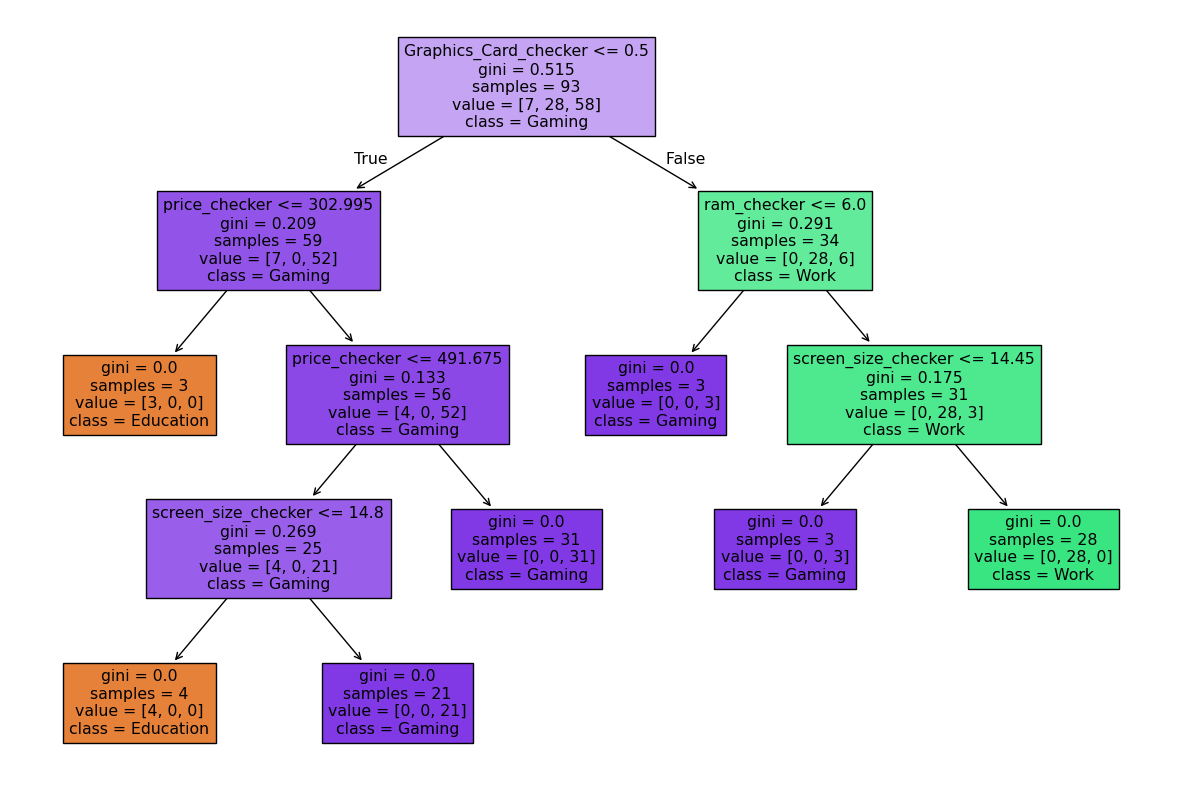

In [408]:
#Prepare Data[Feature(X) and Target(y)]
X=data_cleaned_model[['ram_checker','price_checker','screen_size_checker','Graphics_Card_checker']]
y=data_cleaned_model['Category']

#Split data into train and test:70-30 irrespectively
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,train_size=0.8,random_state=42)

#Build a model
tree=DecisionTreeClassifier()

#Train Model
tree.fit(X_train,y_train)

#Make Predictions
y_pred=tree.predict(X_test)

#Evaluate The Model
accuracy=accuracy_score(y_test,y_pred)
print(f'Model Accuracy:\n{accuracy*100}%')
#Visualize The Model
plt.subplots(figsize=(15,10))
plot_tree(tree,filled=True,feature_names=['ram_checker','price_checker','screen_size_checker','Graphics_Card_checker'],class_names=['Education','Work','Gaming'])
plt.show()

## *Descriptive Analytics*

#### *Understanding the Data*

In [268]:
# 1.Total Number of Laptops
def count(df):
    return df.count()
print(f'There are {count(data_cleaned['Names'])} Laptops')

There are 117 Laptops


In [269]:
# 1.1.Potential Revenue
def sum_total(df):
    return df.sum()
print(f'Potential Revenue: ${sum_total(data_cleaned['Prices_$']).round(2)}')


Potential Revenue: $106399.08


In [270]:
#2.Distribution by Operating System
def groupby_count(df,col,values):
    return df.groupby(col).agg({values:'count'}).sort_values(by=values,ascending=True)
groupby_count(data_cleaned,'Operating_System','Names')

,Names
Operating_System,
FreeDOS,1
Iris,1
Windows 10 Home + Windows 10 Home,1
Window 8.1 Pro,2
Windows 10 Pro + Office 365 1 gadam,2
DOS,5
Win7 Pro 64bit,5
Not Specified,7
Windows 8.1,7


In [271]:
# 3.Distribution by Category
groupby_count(data_cleaned,'Category','Names')

,Names
Category,
Education,7
Gaming,35
Work,75


In [416]:
# 4. What is the average price for laptop in each category?
def ave_by_col(df,col,values):
    return df.groupby(col).agg({values:'mean'}).sort_values(by=values,ascending=True)
ave_by_col(data_cleaned,'Category','Prices_$').round(2)

,Prices_$
Category,
Education,386.34
Work,836.00
Gaming,1171.27


## *Business Questions (Analytical & Performance Evaluation)*


#### *Revenue and Category Contribution:*

In [272]:
# 1. What is the total potential revenue for each category?
def sum_by_col(df,col,values):
    return df.groupby(col).agg({values:'sum'}).sort_values(by=values,ascending=True)
sum_by_col(data_cleaned,'Category','Prices_$')

,Prices_$
Category,
Education,2704.39
Gaming,40994.46
Work,62700.23


In [273]:
# 2. Which category contributes the most and least to overall potential revenue?
print('From Above anaysis:\nContributes Least to potential revenue-Education Category\nContributes High to potential revenue-Work Category')

From Above anaysis:
Contributes Least to potential revenue-Education Category
Contributes High to potential revenue-Work Category


#### *Rating Analysis:*

In [417]:
# 1.What is the average rating for each category?
ave_by_col(data_cleaned,'Category','Ratings').round(2)

,Ratings
Category,
Gaming,2.11
Education,2.43
Work,2.44


In [275]:
## 1.1 What is a maximum rating?
print(f'Maximum Rating: {data_cleaned['Ratings'].max()}')

Maximum Rating: 4


In [276]:
# 2. Which category has the lowest and highest average ratings?
print('From Above anaysis:\nLowest average ratings?-\tGaming Category\nHighest average ratings?-\tWork Category')

From Above anaysis:
Lowest average ratings?-	Gaming Category
Highest average ratings?-	Work Category


In [277]:
# 3.Which specific laptops in each category have the highest and lowest ratings?
data_cleaned.query('`Ratings`==1').groupby(['Category','Names']).min()

Prices_$  \
Category  Names                                                      
Education Asus Eeebook R416Na-Fa014T                        433.30   
          Lenovo Thinkpad E31-80                            404.23   
Gaming    Acer Nitro 5 An515-51                             809.00   
          Acer Predator Helios 300 (Ph317-51)              1221.58   
          Aspire E1-572G                                    581.99   
          Asus Rog Strix Gl553Vd-Dm256                      899.00   
          Asus Rog Strix Gl702Zc-Gc209T                    1769.00   
          Asus Zenbook Ux530Ux-Fy040T Blue                 1239.20   
          Dell Inspiron 15 (7567) Black                    1098.42   
          Dell Latitude 5580                               1337.28   
          Lenovo Legion Y520                               1133.91   
          Msi Gl62M 7Rex                                   1199.00   
          Msi Gl72M 7Rdx                                   1099.00   
          Msi Gp62M 7Rdx Leopard                           1149.00   
          Msi Gs63 7Rd Stealth                             1179.00   
Work      Acer Aspire 3 A315-51                             436.29   
          Acer Aspire Es1-572 Black                         436.29   
          Acer Travelmate P645-S-511A Black                1170.10   
          Apple Macbook Pro                                1333.00   
          Asus Asuspro B9440Ua-Gv0279R Gray                1381.13   
          Asus Vivobook Max X541Na-Gq041 Black Chocolate    399.00   
          Asus Vivobook S14 (S406Ua-Bv041T) Starry Grey     729.00   
          Dell Latitude 5280                               1102.66   
          Dell Latitude 5480                               1271.06   
          Dell Vostro 15 (3568) Red                         497.17   
          Hewlett Packard 250 G6 Dark Ash Silver            364.46   
          Hewlett Packard Probook 640 G3                   1326.83   
          Lenovo Thinkpad T470                             1349.23   
          Lenovo V110-15Ikb                                 465.95   
          Pavilion                                          609.99   
          Thinkpad T540P                                   1178.99   
          Toshiba Portege X20W-D-10V Black/Blue            1366.32   
          Toshiba Portege Z30-C-16J Grey                   1114.55   
          Toshiba Portege Z30-C-16K Grey                   1294.74   
          Toshiba Portege Z30-C-16L Grey                   1154.04   

                                                              Screen_Size  \
Category  Names                                                             
Education Asus Eeebook R416Na-Fa014T                              14" FHD   
          Lenovo Thinkpad E31-80                                 13.3" HD   
Gaming    Acer Nitro 5 An515-51                             15.6" FHD IPS   
          Acer Predator Helios 300 (Ph317-51)               17.3" FHD IPS   
          Aspire E1-572G                                            15.6"   
          Asus Rog Strix Gl553Vd-Dm256                          15.6" FHD   
          Asus Rog Strix Gl702Zc-Gc209T                     17.3" FHD IPS   
          Asus Zenbook Ux530Ux-Fy040T Blue                      15.6" FHD   
          Dell Inspiron 15 (7567) Black                         15.6" FHD   
          Dell Latitude 5580                                    15.6" FHD   
          Lenovo Legion Y520                                    15.6" FHD   
          Msi Gl62M 7Rex                                        15.6" FHD   
          Msi Gl72M 7Rdx                                        15.6" FHD   
          Msi Gp62M 7Rdx Leopard                                15.6" FHD   
          Msi Gs63 7Rd Stealth                              15.6" FHD IPS   
Work      Acer Aspire 3 A315-51                                  15.6" HD   
          Acer Aspire Es1-572 Black                              15.6" HD   
    

In [411]:
data_cleaned.query('`Ratings`==4').groupby(['Category','Names']).max()

Prices_$  \
Category  Names                                                      
Education Prestigio Smartbook 133S Gold                     299.00   
Gaming    Asus Rog Strix Gl702Zc-Gc154T                    1769.00   
          Asus Rog Strix Gl753Ve-Gc096T                    1259.00   
          Lenovo Legion Y520-15Ikbm                        1112.91   
          Msi Gl72M 7Rdx                                   1099.00   
Work      Acer Aspire 3 A315-31 Black                       408.98   
          Acer Aspire 3 A315-51 Black                       494.71   
          Acer Aspire Es1-572 Black                         379.95   
          Acer Aspire Es1-732 Black                         410.46   
          Acer Extensa 15 (2540) Black                      439.73   
          Apple Macbook Air                                1260.13   
          Asus Vivobook 15 X540Na-Gq026T Chocolate Black    410.66   
          Asus Vivobook E502Na-Go022T Dark Blue             399.99   
          Dell Latitude 5480                               1143.40   
          Dell Vostro 15                                    488.78   
          Lenovo Ideapad Miix 510 Platinum Silver          1212.16   
          Lenovo Thinkpad L460                             1096.02   
          Probook                                           739.99   
          Toshiba Portege X30-D-10J Black/Blue             1203.41   

                                                          Discounted_Price_$  \
Category  Names                                                                
Education Prestigio Smartbook 133S Gold                               269.10   
Gaming    Asus Rog Strix Gl702Zc-Gc154T                              1592.10   
          Asus Rog Strix Gl753Ve-Gc096T                              1133.10   
          Lenovo Legion Y520-15Ikbm                                  1001.62   
          Msi Gl72M 7Rdx                                              989.10   
Work      Acer Aspire 3 A315-31 Black                                 368.08   
          Acer Aspire 3 A315-51 Black                                 445.24   
          Acer Aspire Es1-572 Black                                   341.96   
          Acer Aspire Es1-732 Black                                   369.41   
          Acer Extensa 15 (2540) Black                                395.76   
          Apple Macbook Air                                          1134.12   
          Asus Vivobook 15 X540Na-Gq026T Chocolate Black              369.59   
          Asus Vivobook E502Na-Go022T Dark Blue                       359.99   
          Dell Latitude 5480                                         1029.06   
          Dell Vostro 15                                              439.90   
          Lenovo Ideapad Miix 510 Platinum Silver                    1090.94   
          Lenovo Thinkpad L460                                        986.42   
          Probook                                                     628.99   
          Toshiba Portege X30-D-10J Black/Blue                       1083.07   

                                                              Screen_Size  \
Category  Names                                                             
Education Prestigio Smartbook 133S Gold                     13.3" FHD IPS   
Gaming    Asus Rog Strix Gl702Zc-Gc154T                         17.3" FHD   
          Asus Rog Strix Gl753Ve-Gc096T                         17.3" FHD   
          Lenovo Legion Y520-15Ikbm                         15.6" FHD IPS   
          Msi Gl72M 7Rdx                                        17.3" FHD   
Work      Acer Aspire 3 A315-31 Black                            15.6" HD   
          Acer Aspire 3 A315-51 Black                           15.6" FHD   
          Acer Aspire Es1-572 Black                              15.6" HD   
          Acer Aspire Es1-732 Black                             17.3" HD+   
          Acer Extensa 15 (2540) Black                     

## *Discount and Price Changes:*


1. Identify "Old" ('Windows 8.1', 'Linux', 'Win7 Pro 64bit','Windows 8.1 Pro') :
    -Apply a 15% discount to all identified "old" laptops.


In [280]:
laptops_clearance_sale=data_cleaned.query("Operating_System in ['Windows 8.1', 'Win7 Pro 64bit', 'Window 8.1 Pro']")
sale=laptops_clearance_sale['Prices_$'].apply(lambda x: x-x*0.15)
laptops_clearance_sale.insert(2,'Discounted_Price_$',round(sale,2))
laptops_clearance_sale

,Names,Prices_$,Discounted_Price_$,Screen_Size,Processor,Ram,Storage,Graphics_Card,Operating_System,Ratings,Reviews,Category
0,Packard 255 G2,416.99,354.44,"15.6""",AMD E2-3800 1.3GHz,4GB,500GB,Not Specified,Windows 8.1,2,2,Work
2,Thinkpad T540P,1178.99,1002.14,"15.6""",Core i5-4200M,4GB,500GB,Not Specified,Win7 Pro 64bit,1,2,Work
3,Probook,739.99,628.99,"14""",Core i5 2.6GHz,4GB,500GB,Not Specified,Win7 Pro 64bit,4,8,Work
4,Thinkpad X240,1311.99,1115.19,"12.5""",Core i5-4300U,8GB,240GB SSD,Not Specified,Win7 Pro 64bit,3,12,Work
5,Aspire E1-572G,581.99,494.69,"15.6""",Core i5-4200U,8GB,1TB,Radeon R7 M265,Windows 8.1,1,2,Gaming
6,Thinkpad Yoga,1033.99,878.89,"12.5"" Touch",Core i3-4010U,4GB,500GB + 16GB SSD Cache,Not Specified,Window 8.1 Pro,2,13,Work
7,Pavilion,609.99,518.49,"15.6""",Core i5-4200U,6GB,750GB,Not Specified,Windows 8.1,1,4,Work
8,Inspiron 15,745.99,634.09,"15.6""",Core i7-4510U,8GB,1TB,Radeon HD R7 M265 2GB,Window 8.1 Pro,3,12,Gaming
9,Dell Xps 13,1281.99,1089.69,"13.3"" Touch",Core i5-4210U,8GB,128GB SSD,Not Specified,Windows 8.1,3,4,Work
10,Thinkpad X230,1244.99,1058.24,"12.5""",Core i5 2.6GHz,8GB,180GB SSD,Not Specified,Win7 Pro 64bit,3,10,Work


2. *Sale of 10% excluding products in clearance sale


In [281]:
laptops_sale=data_cleaned.query("Operating_System not in ['Windows 8.1', 'Win7 Pro 64bit', 'Window 8.1 Pro'] ")
sale=laptops_sale['Prices_$'].apply(lambda x: x-x*0.10)
laptops_sale.insert(2,'Discounted_Price_$',round(sale,2))
laptops_sale

,Names,Prices_$,Discounted_Price_$,Screen_Size,Processor,Ram,Storage,Graphics_Card,Operating_System,Ratings,Reviews,Category
1,Aspire E1-510,306.99,276.29,"15.6""",Pentium N3520 2.16GHz,4GB,500GB,Not Specified,Linux,3,2,Work
14,Asus Vivobook Max X541Na-Gq041 Black Chocolate,399.00,359.10,"15.6"" HD",Pentium N4200 1.1GHz,4GB,500GB,Not Specified,Windows 10 Home,1,4,Work
15,Dell Vostro 15,488.78,439.90,"15.6"" FHD",Core i5-7200U,4GB,128GB SSD,Radeon R5 M420 2GB,Linux,4,14,Work
16,Acer Spin 5,564.98,508.48,"13.3"" FHD Touch",Core i3-7100U,4GB,128GB SSD,Not Specified,Windows 10 Home,2,0,Work
17,Acer Aspire A515-51-5654,679.00,611.10,"15.6"" FHD",Core i5-8250U,8GB DDR4,256GB SSD,Not Specified,Windows 10 Home,2,9,Work
...,...,...,...,...,...,...,...,...,...,...,...,...
112,Lenovo Thinkpad T470,1349.23,1214.31,"14"" FHD IPS",Core i5-7200U,8GB,256GB SSD,Not Specified,Windows 10 Pro,1,5,Work
113,Lenovo Thinkpad Yoga 370 Black,1362.24,1226.02,"13.3"" FHD IPS Touch",Core i5-7200U,8GB,256GB SSD,4GB,Windows 10 Pro,2,12,Work
114,Toshiba Portege X20W-D-10V Black/Blue,1366.32,1229.69,"12.5"" FHD Touch",Core i7-7500U,8GB,512GB SSD,Not Specified,Windows 10 Pro,1,11,Work
115,Asus Asuspro B9440Ua-Gv0279R Gray,1381.13,1243.02,"14"" FHD",Core i7-7500U,16GB,512GB SSD,Not Specified,Windows 10 Pro,1,4,Work


In [282]:
data_cleaned=pd.concat([laptops_clearance_sale,laptops_sale],ignore_index=True)
data_cleaned

,Names,Prices_$,Discounted_Price_$,Screen_Size,Processor,Ram,Storage,Graphics_Card,Operating_System,Ratings,Reviews,Category
0,Packard 255 G2,416.99,354.44,"15.6""",AMD E2-3800 1.3GHz,4GB,500GB,Not Specified,Windows 8.1,2,2,Work
1,Thinkpad T540P,1178.99,1002.14,"15.6""",Core i5-4200M,4GB,500GB,Not Specified,Win7 Pro 64bit,1,2,Work
2,Probook,739.99,628.99,"14""",Core i5 2.6GHz,4GB,500GB,Not Specified,Win7 Pro 64bit,4,8,Work
3,Thinkpad X240,1311.99,1115.19,"12.5""",Core i5-4300U,8GB,240GB SSD,Not Specified,Win7 Pro 64bit,3,12,Work
4,Aspire E1-572G,581.99,494.69,"15.6""",Core i5-4200U,8GB,1TB,Radeon R7 M265,Windows 8.1,1,2,Gaming
...,...,...,...,...,...,...,...,...,...,...,...,...
112,Lenovo Thinkpad T470,1349.23,1214.31,"14"" FHD IPS",Core i5-7200U,8GB,256GB SSD,Not Specified,Windows 10 Pro,1,5,Work
113,Lenovo Thinkpad Yoga 370 Black,1362.24,1226.02,"13.3"" FHD IPS Touch",Core i5-7200U,8GB,256GB SSD,4GB,Windows 10 Pro,2,12,Work
114,Toshiba Portege X20W-D-10V Black/Blue,1366.32,1229.69,"12.5"" FHD Touch",Core i7-7500U,8GB,512GB SSD,Not Specified,Windows 10 Pro,1,11,Work
115,Asus Asuspro B9440Ua-Gv0279R Gray,1381.13,1243.02,"14"" FHD",Core i7-7500U,16GB,512GB SSD,Not Specified,Windows 10 Pro,1,4,Work


#### *Revenue Optimization (Pricing Strategy)*


Impact of Discounts and Price Changes:

How does the total revenue after price changes compare to the original revenue?

What is the total change in revenue, and is the new total higher or lower than the initial revenue?


##### *Impact of Discounts and Price Changes:*

In [284]:
# 1. What is the total revenue after applying all discounts and price increases?
print(f'Potential Revenue After Price Changes : ${sum_total(data_cleaned['Prices_$'])}')

Potential Revenue After Price Changes : $106399.08000000002


In [285]:
# 1. What is the total revenue after applying all discounts and price increases?
print(f'Potential Revenue After Price Changes : ${sum_total(data_cleaned['Discounted_Price_$'])}')

Potential Revenue After Price Changes : $95128.70000000001


In [286]:
# 2. How does the total revenue after price changes compare to the original revenue?
before_price_changes=sum_total(data_cleaned['Prices_$']).round(2)
after_price_changes=sum_total(data_cleaned['Discounted_Price_$']).round(2)
print(f'Potential Revenue Before Price Changes : $ {before_price_changes}')
print(f'Potential Revenue After Price Changes : $ {after_price_changes}')
change_in_price=before_price_changes-after_price_changes
print(f'Change In Price:$ {change_in_price.round(2)}')

Potential Revenue Before Price Changes : $ 106399.08
Potential Revenue After Price Changes : $ 95128.7
Change In Price:$ 11270.38


##### *Price Change Implications:*

In [287]:
#1. What are the implications of the price changes on overall revenue (e.g., profit margins)?
print(f'Potential Revenue Decreased By:$ {change_in_price.round(2)}')

Potential Revenue Decreased By:$ 11270.38


In [398]:
# 2.Changes in Price By Category
category_before=sum_by_col(data_cleaned,'Category','Prices_$')
category_after=sum_by_col(data_cleaned,'Category','Discounted_Price_$')
#Join tables
category_data=pd.merge(category_before,category_after,on='Category',how='inner')
category_data
#Get Change in Price
category_data['Change_%']=((category_data['Discounted_Price_$']-category_data['Prices_$'])/category_data['Prices_$']*100).round(2)
category_data.insert(0,'Category',category_data.index)

In [291]:
## 5. Export Data (Excel And SQL)
# SQL
db_parameters = {
    # Database parameters
}
try:
    connect = sql.connect(**db_parameters)
    cursor  = connect.cursor()
    
    create_table =''' Create Table If Not Exists laptops_data(
        Id int Primary Key
        ,Name varchar
        ,Prices_$ float
        ,Discounted_Price_$ float
        ,Screen_Size varchar
        ,Processor varchar
        ,Ram varchar
        ,Storage varchar
        ,Graphics_Card varchar
        ,Operating_System varchar
        ,Ratings int
        ,Reviews int
        ,Category varchar
        
    )
    '''
    #Create Table in PostGres
    cursor.execute(create_table)
    #commit Changes
    connect.commit()
    #Clear the existing table before inserting
    cursor.execute('Truncate Table laptops_data')
    #Insert data
    insert_query="""INSERT INTO laptops_data VALUES(%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)"""
    
    for index, row in data_cleaned.iterrows():
        cursor.execute(insert_query,[index
                                     ,row['Names']
                                     ,row['Prices_$']
                                     ,row['Discounted_Price_$']
                                     ,row['Screen_Size']
                                     ,row['Processor']
                                     ,row['Ram']
                                     ,row['Storage']
                                     ,row['Graphics_Card']
                                     ,row['Operating_System']
                                     ,row['Ratings']
                                     ,row['Reviews']
                                     ,row['Category']
                                    ])
    #commit Changes
    connect.commit()
    
except Exception as e:
    print(f'Error:{e}')
finally:
    if connect:
        connect.close()
    if  cursor:
        cursor.close()

In [419]:
# To CSV
data_cleaned.to_csv('data_cleaned.csv')

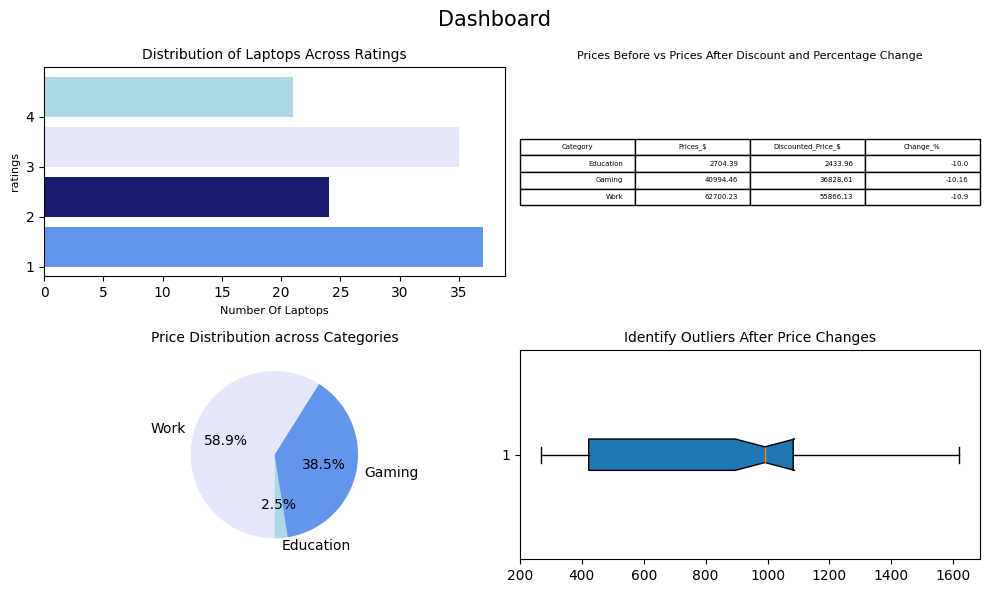

In [412]:
group=data_cleaned.groupby('Ratings').agg({'Names':'count'})

x=group.index.values #Category
y=group.values.flatten()#Total in each Category

#Create a Figure
fig, ax = plt.subplots(2,2,figsize=(10,6))
fig.suptitle('Dashboard',fontsize=15,fontweight=1)

#Bar Plot
color=['cornflowerblue','midnightblue','lavender','lightBlue']
ax[0,0].barh(x,y,color=color,align='edge')
#Labels
ax[0,0].set_title('Distribution of Laptops Across Ratings', color='k',fontsize=None,loc='center')
ax[0,0].set_ylabel('ratings',color='k',fontsize=8)
ax[0,0].set_xlabel('Number Of Laptops',color='k',fontsize=8)
lis=range(1,5,1)
ax[0,0].set_yticks(lis, [x for x in lis])

#Table
ax[0,1].axis('Off')
ax[0,1].table(colLabels=category_data.columns,cellText=category_data.values,loc='center',fontsize=15)
ax[0,1].set_title('Prices Before vs Prices After Discount and Percentage Change',fontsize=8)

#Pie
xc=sum_by_col(data_cleaned,'Category','Prices_$')
color=['lightblue','cornflowerblue','lavender']
ax[1,0].pie(xc['Prices_$'],labels=xc.index,colors=color,autopct="%1.1f%%",startangle=270)
#Labes
ax[1,0].set_title("Price Distribution across Categories",color='k',fontsize=10)

#Box And Whisckers
ax[1,1].boxplot(data_cleaned['Discounted_Price_$'],vert=False, patch_artist=True,notch=True)
ax[1,1].set_title("Identify Outliers After Price Changes",color='k',fontsize=10)

#Display
plt.tight_layout()
plt.savefig('dashboard.png')
plt.show()

